In [1]:
import copy
import os.path
import sys

pwd = os.getcwd()
sys.path.append(os.path.dirname(pwd))

from utils.model_utils.evaluate import evaluate_model
from utils.model_utils.load_model import *
from utils.model_utils.model_config import ModelConfig
from utils.dataset_utils.load_dataset import load_data
from utils.decompose_utils.weight_remover import WeightRemoverBert
from utils.decompose_utils.concern_identification import ConcernIdentificationBert
from utils.decompose_utils.tangling_identification import TanglingIdentification
from transformers import AutoConfig
from utils.model_utils.save_module import save_module
from datetime import datetime
from utils.decompose_utils.concern_modularization import ConcernModularizationBert
from utils.decompose_utils.sampling import sampling_class
from utils.dataset_utils.load_dataset import convert_dataset_labels_to_binary, extract_and_convert_dataloader
import torch


In [2]:
model_name = "sadickam/sdg-classification-bert"
model_type = "pretrained"
data = "OSDG"
num_labels = 16


# model_name = "textattack/bert-base-uncased-imdb"
# model_type = "pretrained"
# data = "IMDb"
# num_labels = 2

# model_name = "fabriceyhc/bert-base-uncased-yahoo_answers_topics"
# model_type = "pretrained"
# data = "Yahoo"
# num_labels = 10

In [3]:
i = 0

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

checkpoint_name = None
config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
model_config = ModelConfig(
    _model_name=model_name,
    _model_type=model_type,
    _data=data,
    _transformer_config=config,
    _checkpoint_name=checkpoint_name,
    _device=device,
)


In [5]:
model, tokenizer, checkpoint = load_classification_model(model_config, train_mode=False)

train_dataloader, valid_dataloader, test_dataloader = load_data(
    model_config, batch_size=32
)

print("Start Time:" + datetime.now().strftime("%H:%M:%S"))
print("#Module " + str(i) + " in progress....")
num_samples = 64

Directory /home/Minwoo/LESN/Decompose/DecomposeBERT/Models/Configs/pretrained/sadickam/sdg-classification-bert exists.
Loading the model.
Start Time:18:13:11
#Module 0 in progress....


In [6]:
positive_samples = sampling_class(
    train_dataloader, i, num_samples, num_labels, True, 4, device=device
)
negative_samples = sampling_class(
    train_dataloader, i, num_samples, num_labels, False, 4, device=device
)

all_samples = sampling_class(
    train_dataloader, 200, 20, num_labels, False, 4, device=device
)

In [7]:
print("origin")
evaluate_model(model, model_config, test_dataloader)

module = copy.deepcopy(model)
wr = WeightRemoverBert(model, p=0.9)
ci = ConcernIdentificationBert(model, p=0.4)
ti = TanglingIdentification(model, p=0.5)

print("Start Positive CI sparse")

origin


Evaluating: 100%|?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ| 400/400 [01:33<00:00,  4.28it/s]


Loss: 0.9480
Precision: 0.7801, Recall: 0.7867, F1-Score: 0.7793
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       797
           1       0.84      0.72      0.78       775
           2       0.88      0.87      0.88       795
           3       0.87      0.83      0.85      1110
           4       0.86      0.80      0.83      1260
           5       0.88      0.69      0.77       882
           6       0.85      0.80      0.83       940
           7       0.49      0.61      0.54       473
           8       0.66      0.85      0.74       746
           9       0.62      0.73      0.67       689
          10       0.75      0.79      0.77       670
          11       0.62      0.81      0.70       312
          12       0.73      0.81      0.77       665
          13       0.83      0.85      0.84       314
          14       0.85      0.78      0.81       756
          15       0.97      0.98      0.97      1607

    accuracy   

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [24]:
def double_plot(tensor1, tensor2):
    tensor_data1 = tensor1.cpu().detach().numpy()
    flatten_data1 = tensor_data1.flatten()

    tensor_data2 = tensor2.cpu().detach().numpy()
    flatten_data2 = tensor_data2.flatten()
    
    fig, ax1 = plt.subplots(figsize=(6, 5))

    # Plotting the first histogram
    ax1.hist(flatten_data1, bins=40, edgecolor='black', alpha=0.5, label='concern identification', color='b')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    # Plotting the second histogram
    ax1.hist(flatten_data2, bins=40, edgecolor='black', alpha=0.5, label='tangling identification', color='y')
    ax1.set_ylabel('Frequency', color='g')
    ax1.tick_params(axis='y', labelcolor='g')

    plt.title('Distribution of the weight')
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
def print_weight(model):
    top_ff1 = model.bert.encoder.layer[0].intermediate.dense.weight
    bottom_ff1 = model.bert.encoder.layer[-1].intermediate.dense.weight
    top_ff2 = model.bert.encoder.layer[0].output.dense.weight
    bottom_ff2 = model.bert.encoder.layer[-1].output.dense.weight
    pooler = model.bert.pooler.dense.weight
    classifier = model.bert.pooler.dense.weight
    plot(top_ff1)
    plot(bottom_ff1)
    plot(top_ff2)
    plot(bottom_ff2)
    plot(pooler)
    plot(classifier)

In [11]:
def print_overlapped_weight(model, module):
    top_ff1 = model.bert.encoder.layer[0].intermediate.dense.weight
    bottom_ff1 = model.bert.encoder.layer[-1].intermediate.dense.weight
    top_ff2 = model.bert.encoder.layer[0].output.dense.weight
    bottom_ff2 = model.bert.encoder.layer[-1].output.dense.weight
    pooler = model.bert.pooler.dense.weight
    classifier = model.bert.pooler.dense.weight

    top_ff1_m = module.bert.encoder.layer[0].intermediate.dense.weight
    bottom_ff1_m = module.bert.encoder.layer[-1].intermediate.dense.weight
    top_ff2_m = module.bert.encoder.layer[0].output.dense.weight
    bottom_ff2_m = module.bert.encoder.layer[-1].output.dense.weight
    pooler_m = module.bert.pooler.dense.weight
    classifier_m = module.bert.pooler.dense.weight

    double_plot(top_ff1, top_ff1_m)
    double_plot(bottom_ff1, bottom_ff1_m)
    double_plot(top_ff2, top_ff2_m)
    double_plot(bottom_ff2, bottom_ff2_m)
    double_plot(pooler, pooler_m)
    double_plot(classifier, classifier_m)

In [12]:
eval_step = 5
for idx, batch in enumerate(all_samples):
    input_ids, attn_mask, _, total_sampled = batch
    with torch.no_grad():
        wr.propagate(module, input_ids)
    if idx % eval_step:
        # result = evaluate_model(module, model_config, test_dataloader)
        pass

print("Start Positive CI after sparse")

Start Positive CI after sparse


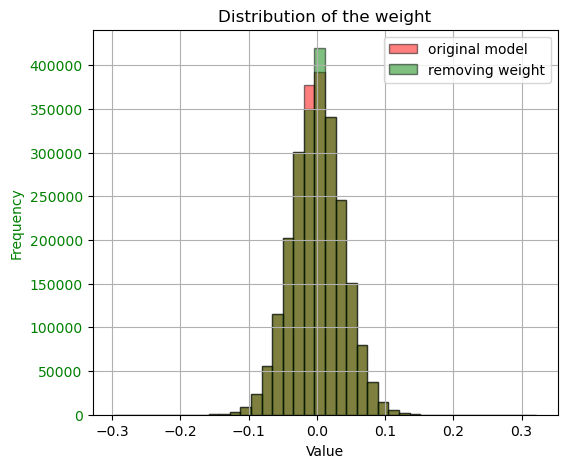

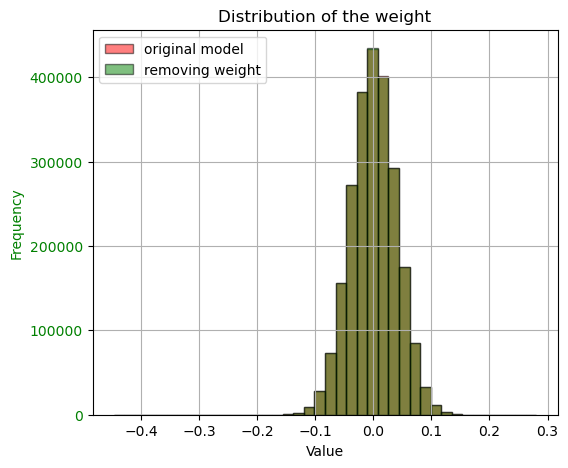

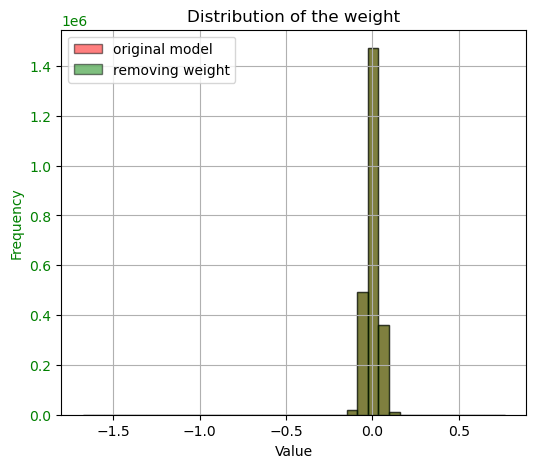

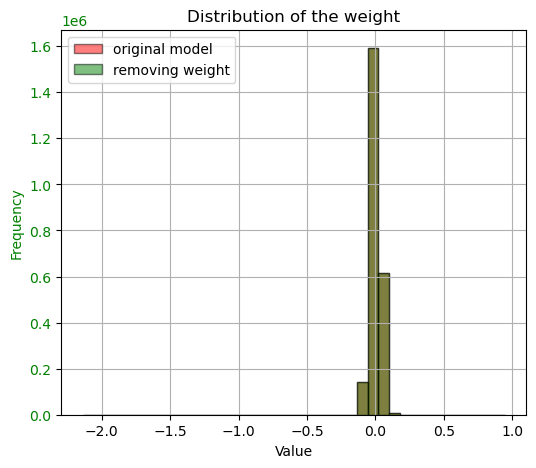

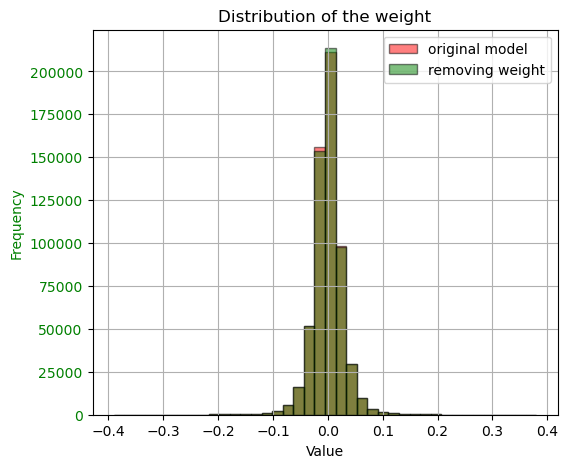

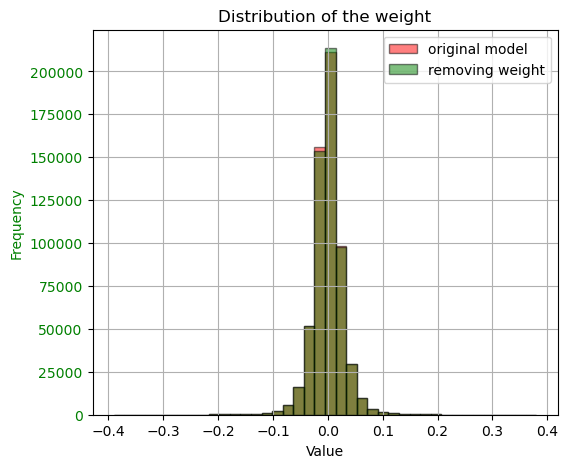

In [17]:
print_overlapped_weight(model, module)

In [19]:
for idx, batch in enumerate(positive_samples):
    input_ids, attn_mask, _, total_sampled = batch
    with torch.no_grad():
        ci.propagate(module, input_ids)
    if idx % eval_step:
        # result = evaluate_model(module, model_config, test_dataloader)
        pass

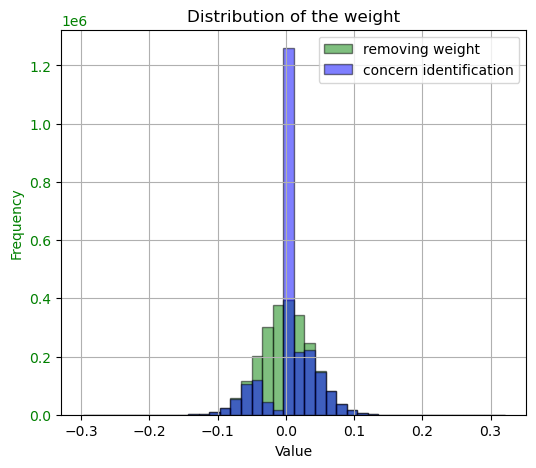

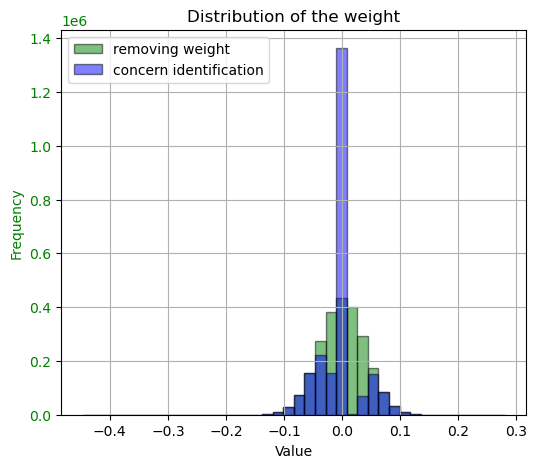

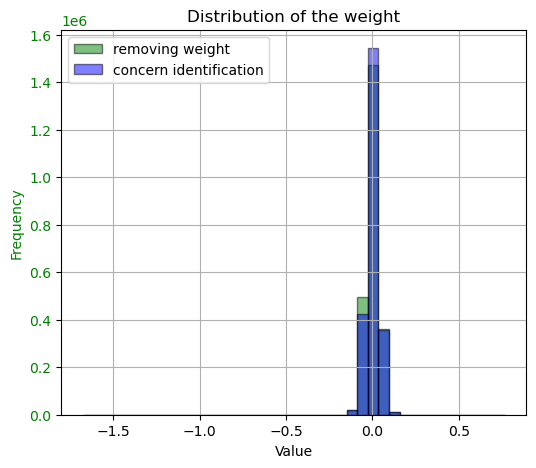

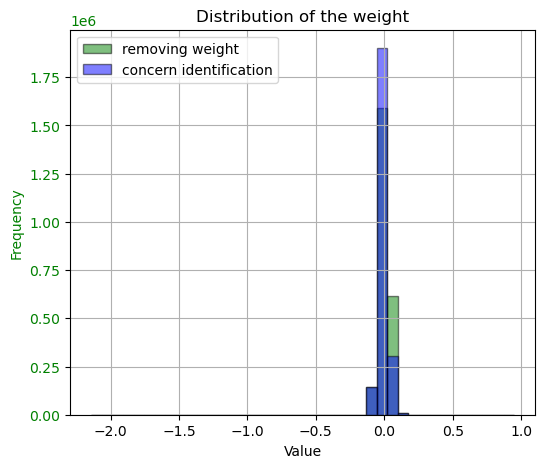

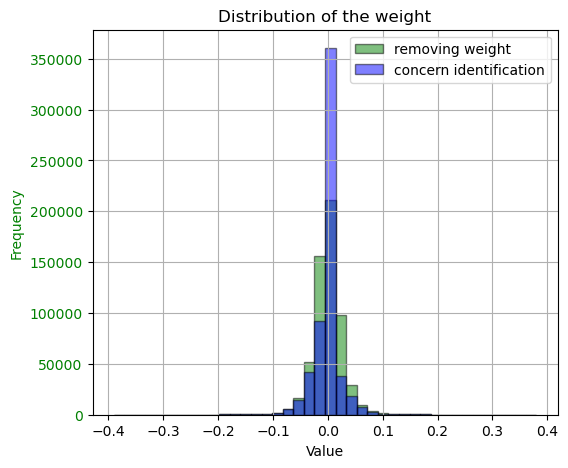

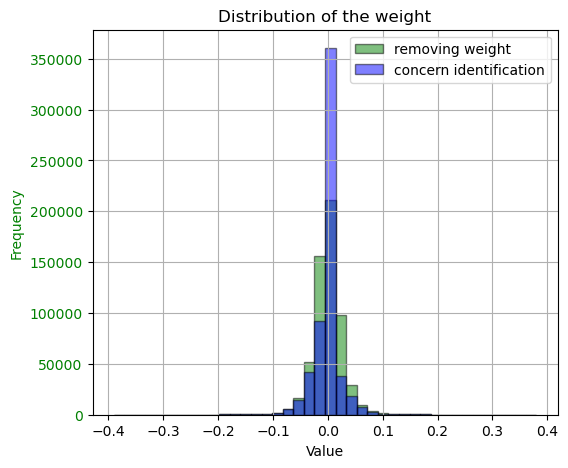

In [22]:
print_overlapped_weight(model, module)
module_cp = copy.deepcopy(module)

In [23]:
print("Start Negative TI")

for idx, batch in enumerate(negative_samples):
    input_ids, attn_mask, _, total_sampled = batch
    with torch.no_grad():
        ti.propagate(module, input_ids)
    if idx % eval_step:
        # result = evaluate_model(module, model_config, test_dataloader)
        pass

Start Negative TI


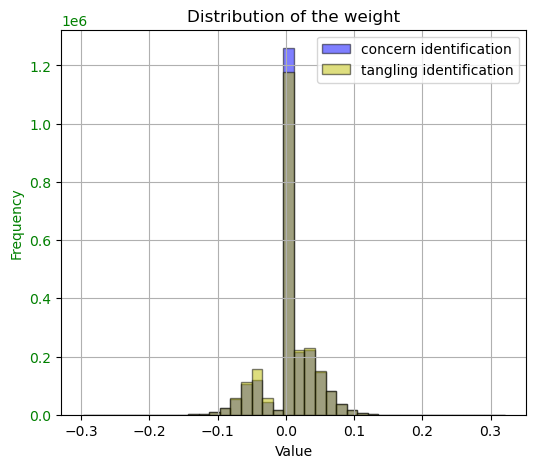

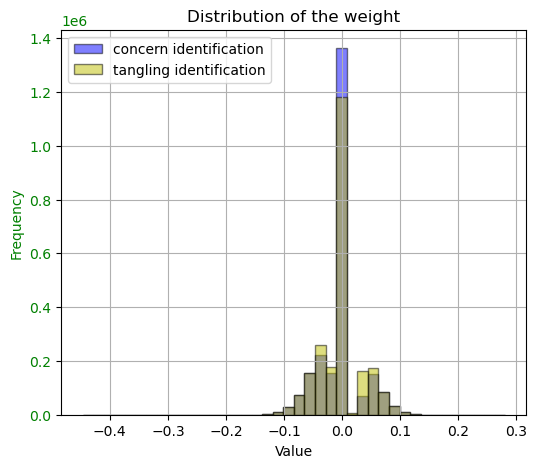

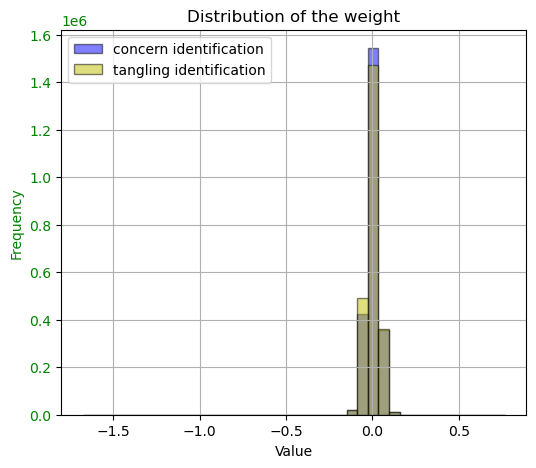

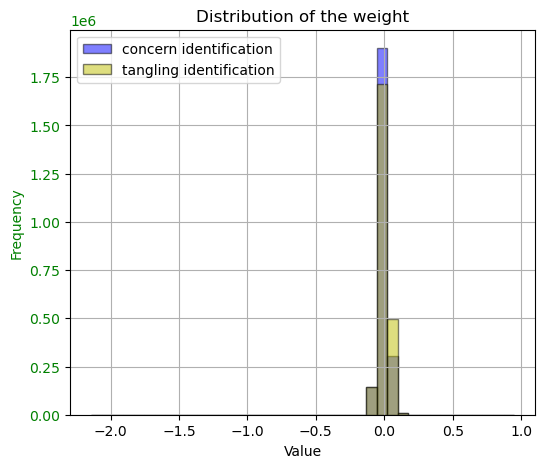

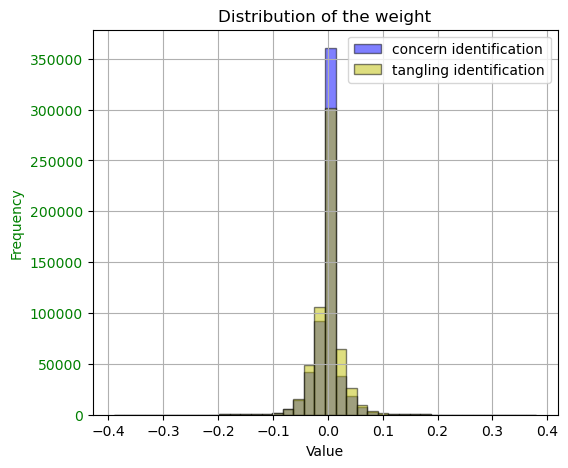

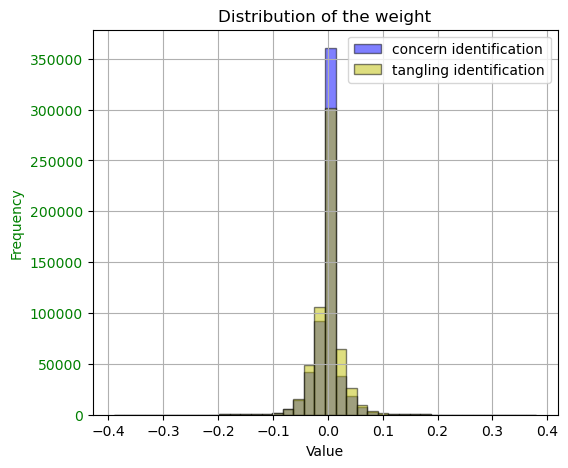

In [25]:
print_overlapped_weight(module_cp, module)

In [20]:
ConcernModularizationBert.channeling(module, ci.active_node, ti.dead_node, i, model_config.device)
binary_module = ConcernModularizationBert.convert2binary(model_config, module)
# save_module(binary_module, model_config.module_dir, model_config.model_name)

converted_test_dataloader = convert_dataset_labels_to_binary(test_dataloader, i, True)
result = evaluate_model(module, model_config, converted_test_dataloader)

dead node 
[1, 2, 7, 8, 9, 10, 15]
active node 
[0, 1, 9, 10, 12, 15]
weight factor 
[0, 10, 9, 0, 0, 0, 0, 9, 11, 16, 16, 0, 0, 0, 0, 16]
weight factor 
[16, 15, 0, 0, 0, 0, 0, 0, 0, 16, 16, 0, 10, 0, 0, 15]


Evaluating: 100%|?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ?–ˆ| 50/50 [00:11<00:00,  4.36it/s]

Loss: 0.5330
Precision: 0.7375, Recall: 0.7045, F1-Score: 0.6939
              precision    recall  f1-score   support

           0       0.83      0.52      0.64       797
           1       0.65      0.89      0.75       797

    accuracy                           0.70      1594
   macro avg       0.74      0.70      0.69      1594
weighted avg       0.74      0.70      0.69      1594



In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
